Create an input file, read or generate the corresponding netcdf simulation file in our database and createa a simple plot

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations


First let us inspect the database class for an overview of how it works

In [2]:
help(simplesim)

Help on module simplesimdb:

NAME
    simplesimdb - Creation and management of simple simulation data

CLASSES
    builtins.object
        Manager
        Repeater
    
    class Manager(builtins.object)
     |  Manager(directory='./data', filetype='nc', executable='./execute.sh')
     |  
     |  Lightweight Simulation Database Manager
     |  
     |  Create, access and display simulation data of a given code as pairs
     |  (inputfile.json : outputfile [, restarted_01, restarted_02, ...]),
     |  where all input is given by python dictionaries (stored as json files)
     |  and the output files (of arbitrary type) are generated by an executable
     |  that takes the json file as input. This executable is provided by the user.
     |  
     |  NOTE: an executable may only take one sinlge input file and may only
     |      generate one single output file (except for RESTART, see below)
     |  NOTE: the executable can be a bash script. For example if the actual program
     |     

First let us generate an input file for path/to/feltor/src/lamb_dipole/shu_b 
Read more about the various parameters in the corresponding documentation

In [3]:
# BE CAREFUL: the inputfile should be very strict on input types,
# i.e. 
# DO NOT WRITE 3.0 INTO A FIELD REQUIRING AN INTEGER
# AND VICE VERSA 10 INTO A FIELD REQUIRING A FLOAT
# else our database manager will treat it as a new entry
inputfile={
    "grid":
    {   
        "type": "Cartesian2d",
        "n"  : 4,
        "Nx" : 36,
        "Ny" : 36,
        "x": [float(0.0),6.283185307179586],
        "y": [float(0),6.283185307179586],
        "bc" : ["PER", "DIR"]
    },
    "timestepper":
    {   
        "type": "FilteredExplicitMultistep",
        "tableau": "eBDF-3-3",
        "dt" : 2.5e-3
    },
    "regularization":
    {   
        "type": "none"
    },
    "output":
    {   
        "type": "netcdf",
        "maxout"  : 40,
        "tend" : 10
    },
    "advection":
    {   
        "multiplication": "projection",
        "type": "upwind"
    },

    "elliptic":
    {   
        "type" : "multigrid",
        "stages": int(3),
        "eps_pol" : [0.000001,10.0, 10.0],
        "direction" : "forward"
    },
    "init": {"type": "shear",
             "rho": 0.20943951023931953,
             "delta": 0.2 },
}

Create a Database in the data folder

In [4]:
m = simplesim.Manager(directory='advection', executable='./execute.sh', filetype='nc')
# Let's see what id the database allocates to our input
print(m.jsonfile(inputfile))

advection/f8ab9773258c67a41b469a5eb4a1c6f17f7dbb4f.json


Now we have to either run the simulation or simply read the output data if it is already available in our data base

In [5]:
ncfile=''
try:
    ncfile=m.create(inputfile)
# the simulation may fail 
except subprocess.CalledProcessError as e:
    print( e.stderr)
print( ncfile)

Existing simulation f8ab97...7dbb4f.nc
advection/f8ab9773258c67a41b469a5eb4a1c6f17f7dbb4f.nc


Let's print the metadata in the netcdf file to see what is inside

In [6]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
print(ncin)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    comment: Find more info in feltor/src/lamb_dipole/shu.tex
    history: 2023-06-01 10:55:28 ../feltor/src/lamb_dipole/shu advection/f8ab9773258c67a41b469a5eb4a1c6f17f7dbb4f.json advection/f8ab9773258c67a41b469a5eb4a1c6f17f7dbb4f.nc
    inputfile: {
	"advection" : 
	{
		"multiplication" : "projection",
		"type" : "upwind"
	},
	"elliptic" : 
	{
		"direction" : "forward",
		"eps_pol" : 
		[
			9.9999999999999995e-07,
			10.0,
			10.0
		],
		"stages" : 3,
		"type" : "multigrid"
	},
	"grid" : 
	{
		"Nx" : 36,
		"Ny" : 36,
		"bc" : 
		[
			"PER",
			"DIR"
		],
		"n" : 4,
		"type" : "Cartesian2d",
		"x" : 
		[
			0.0,
			6.2831853071795862
		],
		"y" : 
		[
			0.0,
			6.2831853071795862
		]
	},
	"init" : 
	{
		"delta" : 0.20000000000000001,
		"rho" : 0.20943951023931953,
		"type" : "shear"
	},
	"output" : 
	{
		"maxout" : 40,
		"tend" : 10,
		"type" : "netcdf"
	},
	"regularization"

Now we can plot the content

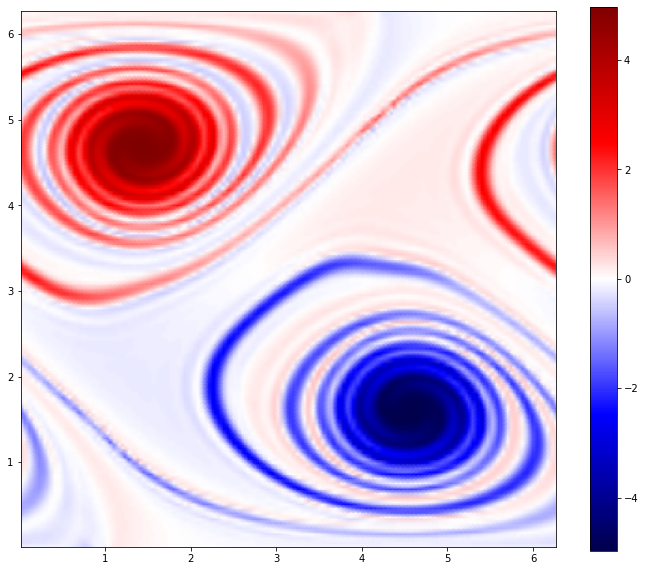

In [7]:
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
vo = ncin["vorticity"][:,:,:]
po = ncin["potential"][:,:,:]
time = ncin["time"][:]
max_idx = np.size( time)-1
plt.figure(figsize=(12, 10))
plt.pcolormesh(xc,yc,vo[max_idx,:,:],
               shading='gouraud',
               cmap = 'seismic' )
plt.colorbar()
plt.axis('scaled')
plt.show()